# NLP Case Study - Automatic Ticket Classification
##### By Sreedhar K and Munirathinam Duraisamy

## Contents:

- [Problem Statement](#Problem_Statement)<br>

- [Pipelines that need to be performed](#Pipelines_that_need_to_be_performed)<br>

- [Importing the necessary libraries](#Importing_the_necessary_libraries)<br>

<a id="Problem_Statement"></a>
## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

<a id="Pipelines_that_need_to_be_performed"></a>
## Pipelines that need to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

<a id="Importing_the_necessary_libraries"></a>
## Importing the necessary libraries

In [1]:
!pip install textblob swifter


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfTransformer
from IPython.display import HTML, display

<a id="Loading_the_data"></a>
## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json') 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

<a id="Data_preparation"></a>
## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
display(
    df.head()
)




,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
#print the column names
display(
    df.shape
)




(78313, 22)

In [6]:
#print the column names
col_list=list(df.columns)
display(
    col_list
)



['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [7]:
display(
    df.info()
)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

None

In [8]:
display(
    df.describe()
)


,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [9]:
#Find the % of null values in each columns
display(
    round(df.isna().sum()*100/78313,2)
)



_index                                0.00
_type                                 0.00
_id                                   0.00
_score                                0.00
_source.tags                         86.08
_source.zip_code                      8.63
_source.complaint_id                  0.00
_source.issue                         0.00
_source.date_received                 0.00
_source.state                         2.54
_source.consumer_disputed             0.00
_source.product                       0.00
_source.company_response              0.00
_source.company                       0.00
_source.submitted_via                 0.00
_source.date_sent_to_company          0.00
_source.company_public_response      99.99
_source.sub_product                  13.50
_source.timely                        0.00
_source.complaint_what_happened       0.00
_source.sub_issue                    59.12
_source.consumer_consent_provided     1.29
dtype: float64

In [10]:
#Assign new column names
#Removing "_" and "source." from column names
df.columns=[re.sub('^_','',col) for col in df.columns]

df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]

display(
    list(df.columns)
)



['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [11]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("", np.nan, inplace=True)



/tmp/ipykernel_2536/1894195231.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [12]:
#Remove all rows where complaints column is nan
#Dropping NaN rows from "_source.complaint_what_happened"
df.dropna(subset=['complaint_what_happened'], inplace=True)


In [13]:
#New shape of df
display(
    df.shape
)


(21072, 22)

<a id="Prepare_the_text_for_topic_modeling"></a>
## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [14]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_texts(text):
    text = text.lower() # to lower case
    text = text.strip() # trim operation
    text = re.sub(r"[\[].*?[\]]","",text).strip() #remove within square bracket
    text = re.sub(r"[^\w\s]","",text).strip() # remove punctuation
    text = re.sub("\S*\d\S*","",text).strip() # remove words containing numbers
    return text

<>:7: SyntaxWarning:

invalid escape sequence '\S'

<>:7: SyntaxWarning:

invalid escape sequence '\S'

/tmp/ipykernel_2536/3313462645.py:7: SyntaxWarning:

invalid escape sequence '\S'



In [15]:
#Cleaning df['complaint_what_happened']
df['complaint_what_happened']= df['complaint_what_happened'].apply(lambda x: clean_texts(x))

In [16]:
# Import the necessary libraries for cleanup
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


#!pip install swifter

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [17]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import swifter # 


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [18]:
#Write your function to Lemmatize the texts
stopwords = stopwords.words('english')
wordnet_lem = WordNetLemmatizer()

def lemma_texts(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords]
    proc_token = []
    for word,pos in pos_tag(tokens):
        try:
            proc_token.append(wordnet_lem.lemmatize(word,pos = pos[0].lower()))
        except:
            proc_token.append(wordnet_lem.lemmatize(word))
    lemmatized_value = ' '.join(proc_token)
    return lemmatized_value

In [19]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

# Add a column for lemmatized complaints to the dataframe
df["lemmatized_complaint"] =  df["complaint_what_happened"].swifter.apply(lemma_texts)

# View the dataframe
display(
    df.head()
)
    

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
Pandas Apply: 100%|██████████| 21072/21072 [01:56<00:00, 181.65it/s]


,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning name xxxx xxxx appreciate could h...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told ...,Problem with rewards from credit card,Consent provided,upgraded xxxx xxxx card tell agent upgrade ann...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent...,Information belongs to someone else,Consent provided,chase card report however fraudulent applicati...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a xxxx xxxx ticket ...,Information belongs to someone else,Consent provided,try book xxxx xxxx ticket come across offer ap...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it i...,Funds not handled or disbursed as instructed,Consent provided,grand son give check deposit chase account fun...


In [20]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean=df[['complaint_what_happened','lemmatized_complaint']]



In [21]:
display(
    df_clean
)


,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...
10,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...
11,on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...
...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offer multiple...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yrs ive chase credit card chas...


In [22]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here

 # Creating a textblob object
    text_blob = TextBlob(text)
    
    # extracting words with tags 'NN', joining them and return
    return ' '.join([ word for (word,tag) in text_blob.tags if tag == "NN"])


df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: pos_tag(x['lemmatized_complaint']), axis=1)
 #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
#Reassigning index of cleaned dataframe
df_clean.reset_index(drop=True, inplace = True)

# View the dataframe
display(
    df_clean.head()
)



/tmp/ipykernel_2536/426560411.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...,xxxx card tell agent date information order up...
2,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,card report application submit identity consen...
3,on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...,book ticket come offer apply ticket card infor...
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...


In [23]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
display(
    df_clean
)

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...,xxxx card tell agent date information order up...
2,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,card report application submit identity consen...
3,on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...,book ticket come offer apply ticket card infor...
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...
...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offer multiple...,chase card customer decade offer solicitation ...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,call chas xxxx credit card provider claim purc...
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase year trust ...
21070,i have had flawless credit for yrs ive had ch...,flawless credit yrs ive chase credit card chas...,flawless credit chase credit card chase freedo...


<a id="EDA"></a>
## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [24]:
#length of character in 'complaint_POS_removed'
char_len=[len(x) for x in df_clean['complaint_POS_removed']]
display(
    char_len[:10]
)

[175, 117, 81, 411, 169, 7, 564, 605, 1268, 45]

Text(0.5, 0, 'Complaint Character length ranges')

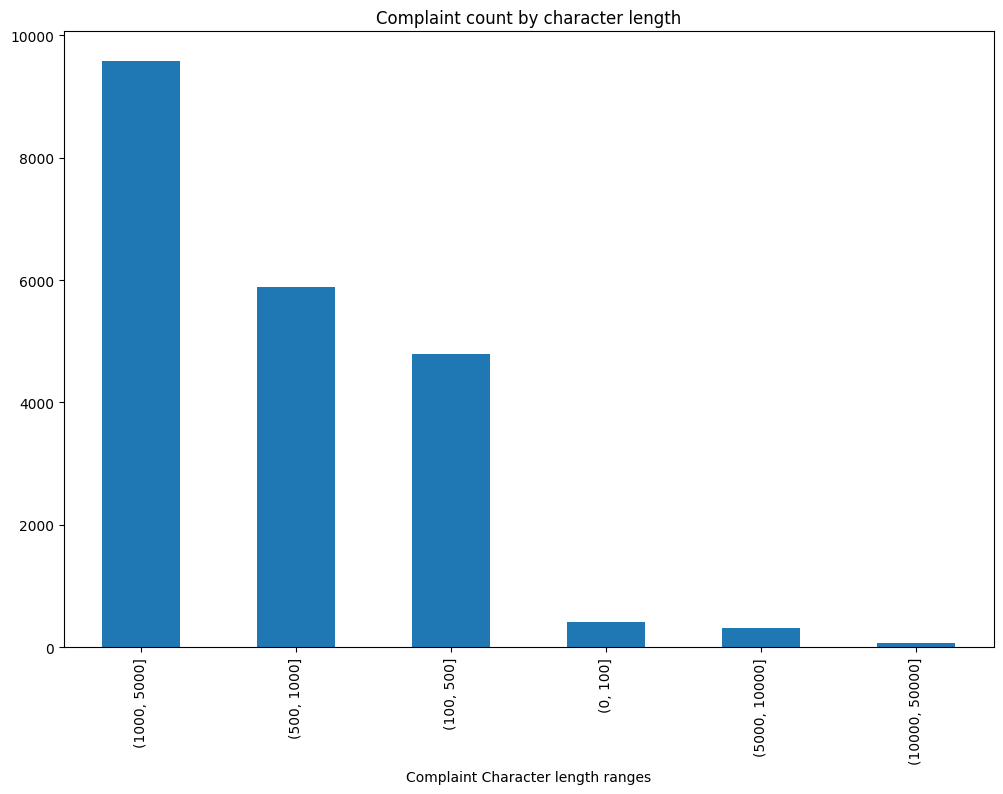

In [25]:
# Write your code here to visualise the data according to the 'Complaint' character length
bins = [0, 100, 500, 1000, 5000, 10000, 50000]
temp_df = df_clean['complaint_what_happened'].str.len().to_frame()
temp_df.columns = ["length"]
temp_df['binned'] = pd.cut(temp_df['length'], bins)
temp_df.binned.value_counts()

plt.figure(figsize=(12,8))
temp_df.binned.value_counts().plot(kind="bar")
plt.title("Complaint count by character length")
plt.xlabel("Complaint Character length ranges")

#### Find the top 40 words by frequency among all the articles after processing the text.

Text(0.5, 1.0, 'Most frequent words in complaints after processing')

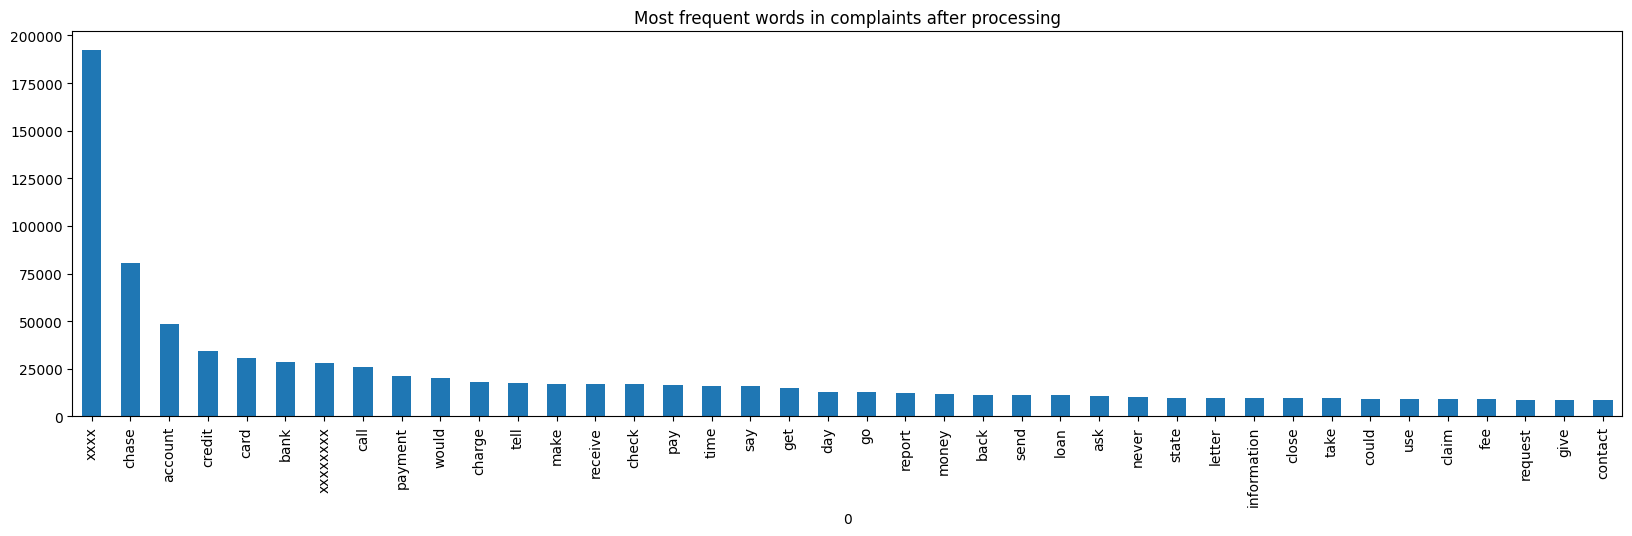

In [26]:
# Most frequent words in the processed (lemmatized) complaints

most_freq_lem=[]
for complaint in df_clean['lemmatized_complaint']:
    for word in complaint.split(' '):
        most_freq_lem.append(word)

plt.figure(figsize=(20, 5)) 
pd.DataFrame(most_freq_lem)[0].value_counts().head(40).plot(kind='bar')
plt.title("Most frequent words in complaints after processing")

In [27]:
!pip install wordcloud


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


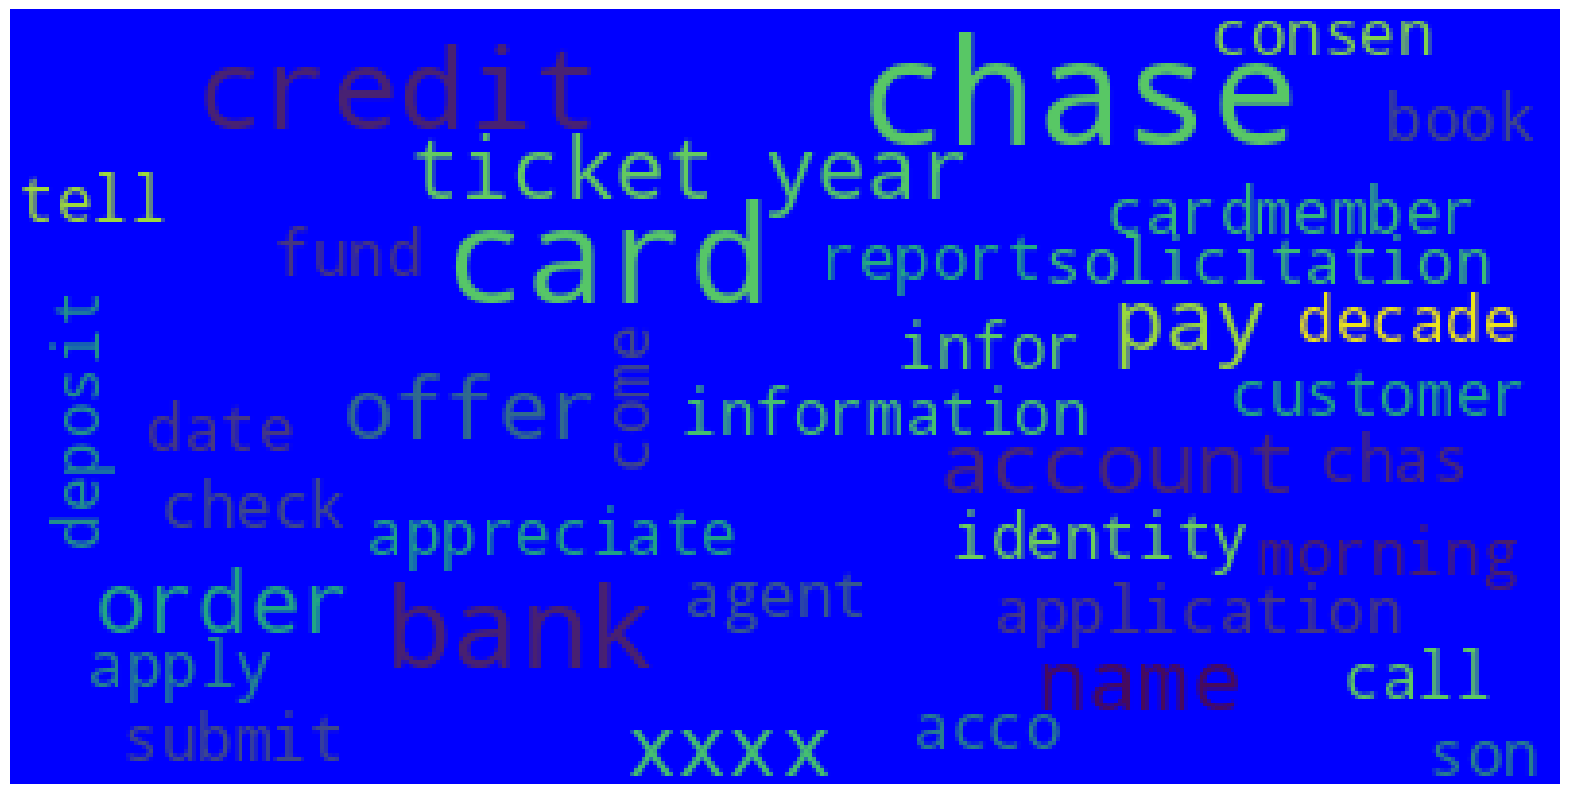

In [28]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS
stop_words = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='blue',
                          stopwords=stop_words,
                          max_font_size=38,
                          max_words=38, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,16))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

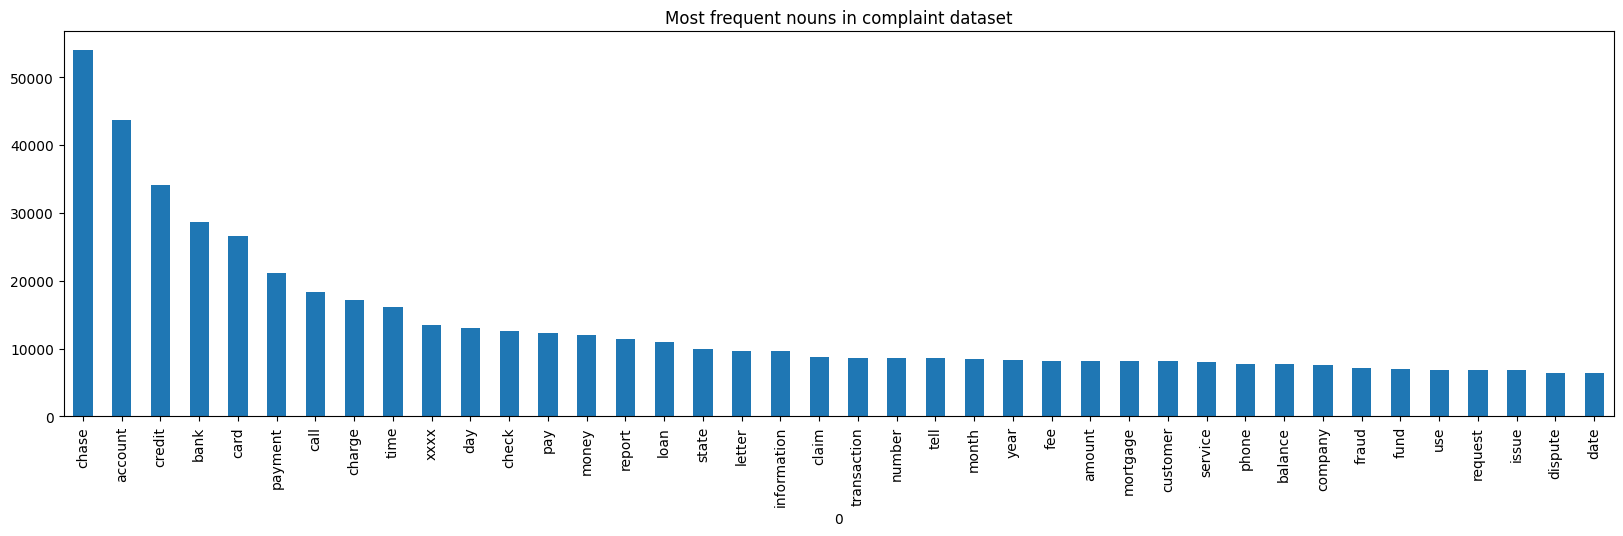

In [29]:
# Most frequent nouns in the processed complaints
most_freq_nouns=[] 
for complaint in df_clean['complaint_POS_removed']:
    for word in complaint.split(' '):
        most_freq_nouns.append(word)

plt.figure(figsize=(20, 5)) 
pd.DataFrame(most_freq_nouns)[0].value_counts().head(40).plot(kind='bar')
plt.title("Most frequent nouns in complaint dataset")
plt.show()

In [30]:
#Removing -PRON- from the text corpus
df_clean['complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
display(
    df_clean
)

/tmp/ipykernel_2536/239405441.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,morning name appreciate chase bank cardmember ...
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...,xxxx card tell agent date information order up...,xxxx card tell agent date information order up...
2,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,card report application submit identity consen...,card report application submit identity consen...
3,on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...,book ticket come offer apply ticket card infor...,book ticket come offer apply ticket card infor...
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,son check deposit chase account fund bank acco...
...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offer multiple...,chase card customer decade offer solicitation ...,chase card customer decade offer solicitation ...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,call chas xxxx credit card provider claim purc...,call chas xxxx credit card provider claim purc...
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase year trust ...,pay risk consumer chase bank chase year trust ...
21070,i have had flawless credit for yrs ive had ch...,flawless credit yrs ive chase credit card chas...,flawless credit chase credit card chase freedo...,flawless credit chase credit card chase freedo...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [31]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_unigram(text, n=30):

    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [32]:
#Print the top 10 words in the unigram frequency
top_common_words = get_top_unigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
display(
    df_unigram.head(10)
)

,unigram,count
0,chase,54053
1,account,43634
2,credit,34082
3,bank,28638
4,card,26588
5,payment,21167
6,charge,17103
7,time,16067
8,xxxx,13422
9,day,12972


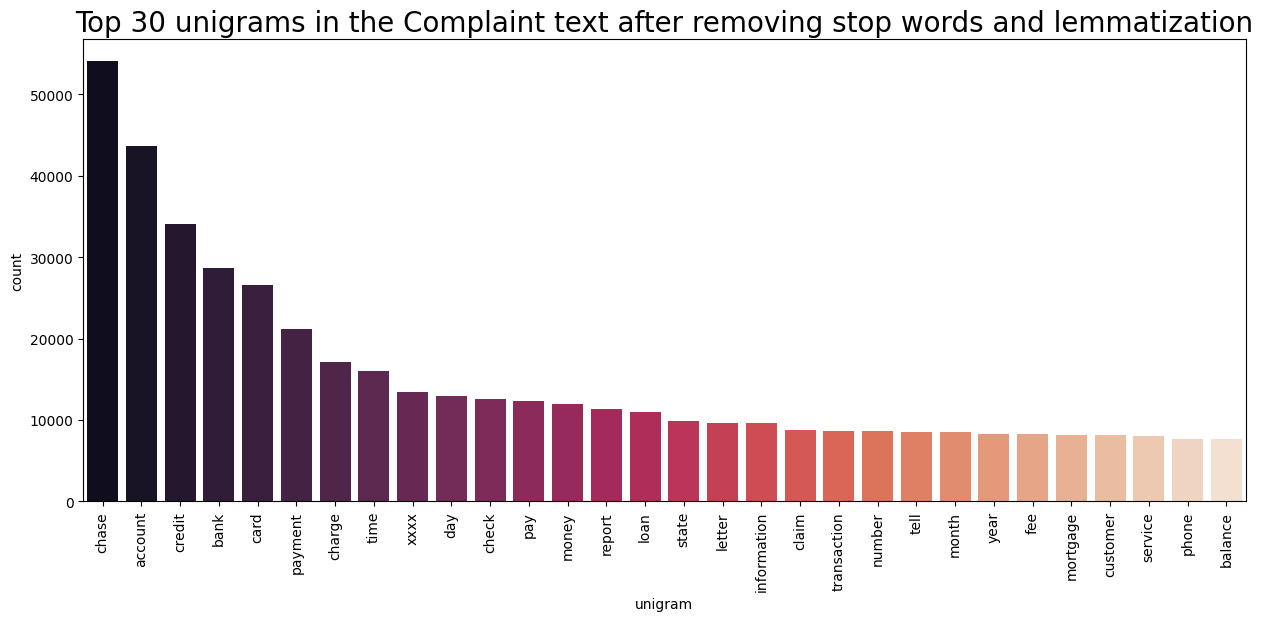

In [33]:
# Top 30 words by their frequency
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=df_unigram, palette="rocket")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [34]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_bigram(text, n=30):

    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [35]:
#Print the top 10 words in the bigram frequency
top_common_words = get_top_bigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])
display(
    df_bigram.head(10)
)

,bigram,count
0,credit card,12605
1,chase bank,5424
2,credit report,4044
3,check account,3740
4,customer service,3074
5,chase credit,3011
6,bank account,2512
7,account chase,2277
8,chase account,2075
9,account account,1869


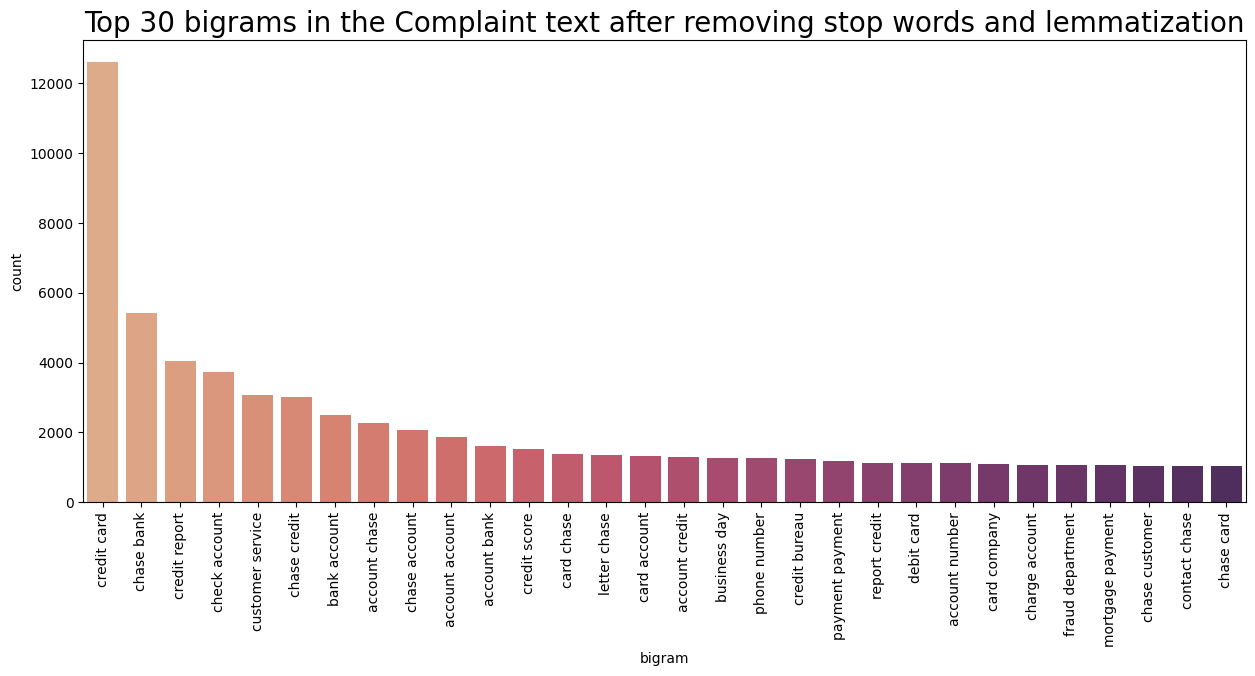

In [36]:
# Plot the top 30 bigrams
plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=df_bigram, palette="flare")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [37]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_trigram(text, n=30):

    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [38]:
#Print the top 10 words in the trigram frequency
top_common_words = get_top_trigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
display(
    df_trigram.head(10)
)

,trigram,count
0,chase credit card,2157
1,credit card company,1000
2,credit card account,909
3,credit card chase,708
4,credit card credit,490
5,chase customer service,489
6,charge credit card,486
7,inquiry credit report,413
8,chase check account,379
9,credit report credit,375


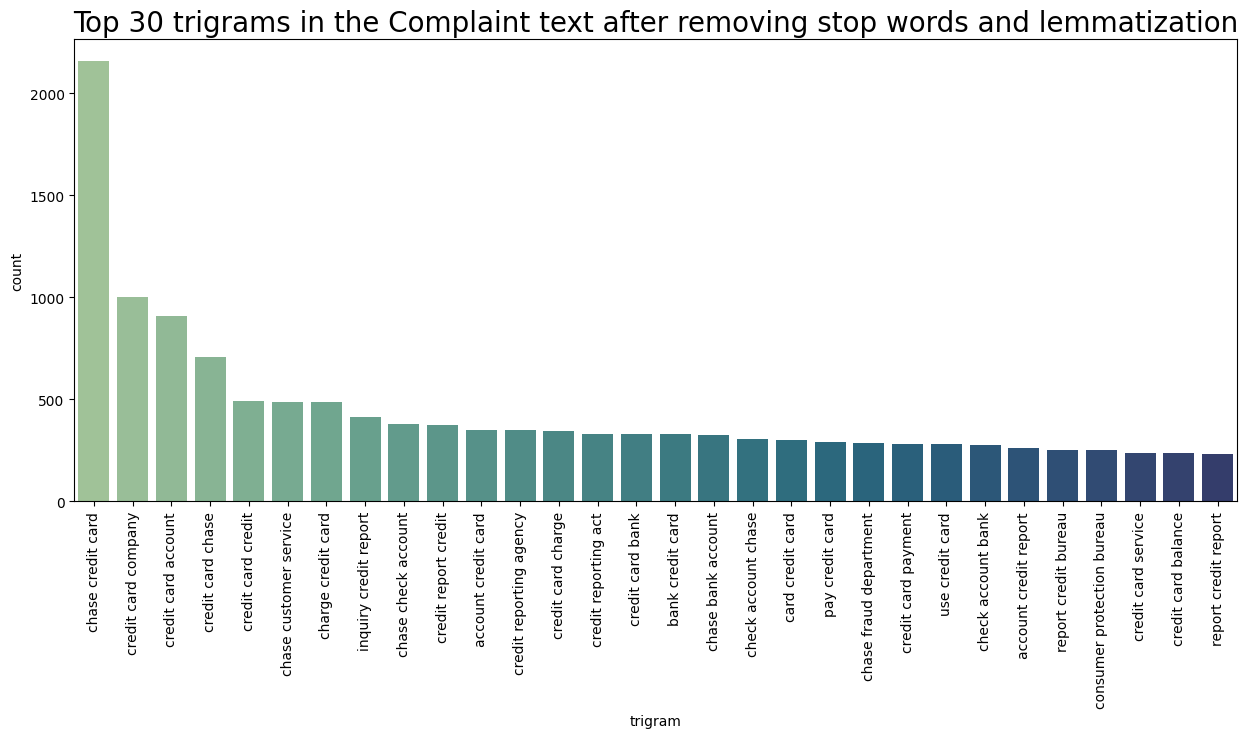

In [39]:
# Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df_trigram, palette="crest")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [40]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx','')
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

/tmp/ipykernel_2536/2908784379.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2536/2908784379.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
#All masked texts has been removed
display(
    df_clean
)

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,morning name appreciate chase bank cardmember ...
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...,card tell agent date information order upgrad...,card tell agent date information order upgrad...
2,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,card report application submit identity consen...,card report application submit identity consen...
3,on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...,book ticket come offer apply ticket card infor...,book ticket come offer apply ticket card infor...
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,son check deposit chase account fund bank acco...
...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offer multiple...,chase card customer decade offer solicitation ...,chase card customer decade offer solicitation ...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,call chas credit card provider claim purchase...,call chas credit card provider claim purchase...
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase year trust ...,pay risk consumer chase bank chase year trust ...
21070,i have had flawless credit for yrs ive had ch...,flawless credit yrs ive chase credit card chas...,flawless credit chase credit card chase freedo...,flawless credit chase credit card chase freedo...


<a id="Feature_Extraction"></a>
## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [42]:
# Taking a copy of df_clean
df_cleaner=df_clean.copy()
#df_clean=df_cleaner.copy()

In [43]:
display(
    df_cleaner.shape
)

(21072, 4)

In [44]:
display(
    df_clean.shape
)


(21072, 4)

In [45]:
#Write your code here to initialise the TfidfVectorizer 

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.95,
    stop_words='english',
    max_features=5000,
    ngram_range=(1, 3)
)



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [46]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf = tfidf_vectorizer.fit_transform(df_clean['complaint_POS_removed'])
features = tfidf_vectorizer.get_feature_names_out()

# Creating a dataframe to display the document-term matrix created above
tfidf_df = pd.DataFrame(tfidf.toarray(), columns = features)
display(
    tfidf_df.head()
)

,ability,abuse,accept,acceptance,access,access account,access bank,access chase,access credit,access fund,...,year try,year use,year work,year year,yesterday,york,youre,yr,zero,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# Check the shape of dataframe
display(
    tfidf_df.shape
)

(21072, 5000)

<a id="Topic_Modelling"></a>
## Topic Modelling

### Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [48]:
from sklearn.decomposition import NMF

### Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [49]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) 
display(
    len(tfidf_vectorizer.get_feature_names_out())
)

5000

In [50]:
W = nmf_model.fit_transform(tfidf)  # Document-Topic matrix
H = nmf_model.components_ 

In [51]:
#Print the Top15 words for each of the topics
words = np.array(tfidf_vectorizer.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

display(topic_words)

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,money,chase,deposit,fund,transaction,check account,day,branch,claim,chase bank,number,transfer
Topic 2,card,charge,credit card,credit,chase,dispute,purchase,chase credit,chase credit card,service,merchant,use,company,fee,time
Topic 3,loan,mortgage,home,chase,modification,property,year,letter,time,sale,rate,house,foreclosure,document,loan modification
Topic 4,credit,report,credit report,inquiry,inquiry credit,account,report credit,inquiry credit report,bureau,debt,credit bureau,reporting,information,score,card
Topic 5,payment,pay,balance,month,payment payment,fee,statement,payment chase,time,auto,day,payment month,chase payment,chase,payment credit


In [52]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_mapping = {
    'Topic 1' : 0,
    'Topic 2' : 1,
    'Topic 3' : 2,
    'Topic 4' : 3,
    'Topic 5' : 4
}



In [53]:
W = pd.DataFrame(W, columns=[f'Topic {i+1}' for i in range(num_topics)])
W['max_topic'] = W.apply(lambda x: topic_mapping.get(x.idxmax()) if x.idxmax() in topic_mapping.keys() else '4', axis=1)
display(
    W[pd.notnull(W['max_topic'])].head(10)
)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.021201,0.005826,0.017941,0.012899,0.004092,0
1,0.011024,0.020624,0.008308,0.003804,0.002003,1
2,0.000000,0.016793,0.000000,0.048230,0.000000,3
3,0.014433,0.017715,0.014105,0.068182,0.000000,3
4,0.057051,0.000000,0.000000,0.000000,0.000000,0
5,0.000000,0.000000,0.000000,0.077797,0.000000,3
6,0.050587,0.001832,0.001680,0.000000,0.010811,0
7,0.002889,0.004961,0.042764,0.001320,0.058810,4
8,0.036754,0.021427,0.016825,0.004189,0.002278,0
9,0.000000,0.042758,0.000000,0.070896,0.000000,3


In [54]:
# Checking the frequency
display(
    W['max_topic'].value_counts()
)

max_topic
1    6305
0    5892
2    3705
3    2760
4    2410
Name: count, dtype: int64

In [55]:
display(
    df_clean.shape
)

(21072, 4)

In [56]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] =  W['max_topic'].apply(lambda x:int(x)) #write your code to assign topics to each rows.

/tmp/ipykernel_2536/1061777978.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [57]:
display(df_clean.shape)

(21072, 5)

In [58]:
display(df_clean.head())

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,morning name appreciate chase bank cardmember ...,0
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...,card tell agent date information order upgrad...,card tell agent date information order upgrad...,1
2,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,card report application submit identity consen...,card report application submit identity consen...,3
3,on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...,book ticket come offer apply ticket card infor...,book ticket come offer apply ticket card infor...,3
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,son check deposit chase account fund bank acco...,0


In [59]:
display(df_clean.shape)

(21072, 5)

In [60]:
# Checking the frequency
display(W['max_topic'].value_counts())


max_topic
1    6305
0    5892
2    3705
3    2760
4    2410
Name: count, dtype: int64

In [61]:
#Print the first 5 Complaint for each of the Topics
df_clean_topic=df_clean.groupby('Topic').head(5)
display(
    df_clean_topic.sort_values('Topic')
)

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,morning name appreciate chase bank cardmember ...,0
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,son check deposit chase account fund bank acco...,0
10,mishandling of this account by chase auto and ...,mishandle account chase auto xxxx,account auto,account auto,0
6,with out notice jp morgan chase restricted my ...,notice jp morgan chase restrict account debit ...,jp restrict account debit card tuesday thursda...,jp restrict account debit card tuesday thursda...,0
8,on xxxx i made a payment to an online retail...,xxxx make payment online retailer use chase qu...,payment online retailer use pay chase website ...,payment online retailer use pay chase website ...,0
21,i am a senior citizen that has been scammed by...,senior citizen scammed several company xxxx xx...,citizen company pay time share company nothing...,citizen company pay time share company nothing...,1
19,i made a purchase with xxxx xxxx xxxx on in t...,make purchase xxxx xxxx xxxx amount charge twi...,purchase amount charge transaction place dispu...,purchase amount charge transaction place dispu...,1
14,my chase amazon card was declined for a cateri...,chase amazon card decline cater order place br...,chase decline cater order place amount contact...,chase decline cater order place amount contact...,1
13,to whom it may concern chase bank charged wron...,may concern chase bank charge wrongly overdraf...,concern bank charge fee alert balance fee bala...,concern bank charge fee alert balance fee bala...,1
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...,card tell agent date information order upgrad...,card tell agent date information order upgrad...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [62]:
#Create the dictionary of Topic names and Topics

Topic_names = {    0 : "Bank account services",
                1 : "Credit Card/Prepaid Card",
                2 : "Mortgages/loans",
                3 : "Theft/Dispute reporting",
                4 : "Others" }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/tmp/ipykernel_2536/4012135675.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [63]:
display(df_clean)

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,morning name appreciate chase bank cardmember ...,Bank account services
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...,card tell agent date information order upgrad...,card tell agent date information order upgrad...,Credit Card/Prepaid Card
2,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,card report application submit identity consen...,card report application submit identity consen...,Theft/Dispute reporting
3,on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...,book ticket come offer apply ticket card infor...,book ticket come offer apply ticket card infor...,Theft/Dispute reporting
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,son check deposit chase account fund bank acco...,Bank account services
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offer multiple...,chase card customer decade offer solicitation ...,chase card customer decade offer solicitation ...,Credit Card/Prepaid Card
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,call chas credit card provider claim purchase...,call chas credit card provider claim purchase...,Credit Card/Prepaid Card
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase year trust ...,pay risk consumer chase bank chase year trust ...,Bank account services
21070,i have had flawless credit for yrs ive had ch...,flawless credit yrs ive chase credit card chas...,flawless credit chase credit card chase freedo...,flawless credit chase credit card chase freedo...,Others


In [64]:
display(df_clean.shape)

(21072, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [65]:
#Create the dictionary again of Topic names and Topics

Topic_names = {  
    "Bank account services" : 0,
    "Credit Card/Prepaid Card" : 1,
    "Mortgages/loans" : 2,
    "Theft/Dispute reporting" : 3,
    "Others" : 4
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/tmp/ipykernel_2536/760086144.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [66]:
display(df_clean)

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,morning name appreciate chase bank cardmember ...,0
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card tell agent upgrade ann...,card tell agent date information order upgrad...,card tell agent date information order upgrad...,1
2,chase card was reported on however fraudulent...,chase card report however fraudulent applicati...,card report application submit identity consen...,card report application submit identity consen...,3
3,on while trying to book a xxxx xxxx ticket ...,try book xxxx xxxx ticket come across offer ap...,book ticket come offer apply ticket card infor...,book ticket come offer apply ticket card infor...,3
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,son check deposit chase account fund bank acco...,0
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,chase card customer well decade offer multiple...,chase card customer decade offer solicitation ...,chase card customer decade offer solicitation ...,1
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,call chas credit card provider claim purchase...,call chas credit card provider claim purchase...,1
21069,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase year trust ...,pay risk consumer chase bank chase year trust ...,0
21070,i have had flawless credit for yrs ive had ch...,flawless credit yrs ive chase credit card chas...,flawless credit chase credit card chase freedo...,flawless credit chase credit card chase freedo...,4


In [67]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["complaint_what_happened", "Topic"]]

In [68]:
display(training_data)

,complaint_what_happened,Topic
0,good morning my name is xxxx xxxx and i apprec...,0
1,i upgraded my xxxx xxxx card in and was told ...,1
2,chase card was reported on however fraudulent...,3
3,on while trying to book a xxxx xxxx ticket ...,3
4,my grand son give me check for i deposit it i...,0
...,...,...
21067,after being a chase card customer for well ove...,1
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,1
21069,i am not familiar with xxxx pay and did not un...,0
21070,i have had flawless credit for yrs ive had ch...,4


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [69]:
#Write your code to get the Vector count
count_vector = CountVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.95, min_df=0.02)
vector = count_vector.fit_transform(training_data['complaint_what_happened'])
display(vector.toarray())

#Write your code here to transform the word vector to tf-idf

tfidf_transformer =TfidfTransformer(use_idf=True).fit(vector)
word_vect = tfidf_transformer.transform(vector)
display("\nTransformed Word vector to Tf-idf : {}".format(word_vect.shape))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 3, 1, 0]])

'\nTransformed Word vector to Tf-idf : (21072, 820)'

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [70]:


# Function to evaluate metrics
from sklearn import metrics

def accuracy_evaluation(y_actual,y_pred,model_name):
    
    # print classification report of classifier
    display(f"CLASSIFICATION REPORT for {model_name}\n")
    display(metrics.classification_report(y_actual, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
       
    # Confusion matrix
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    confusion = metrics.confusion_matrix(y_actual, y_pred)
    
    sns.heatmap(confusion, annot=True, cbar=None, cmap="Greens", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()

    # Metrics calculation
    accuracy = metrics.accuracy_score(y_actual,y_pred)
    clf_report = metrics.classification_report(y_actual,y_pred)   # Sklearn classification report
    
    display("Accuracy   : " + str(accuracy))
    
    
    
    return accuracy



### Train Model and Evaluation

In [71]:
# Train_Df 

train_df = pd.DataFrame(word_vect.toarray(),columns=count_vector.get_feature_names_out(),index=training_data.index)
display(
    train_df.head()
)

,ability,able,absolutely,accept,accepted,access,according,account,account called,account chase,...,xxxxxxxx chase,xxxxxxxx received,xxxxxxxx xxxx,xxxxxxxx xxxx xxxx,xxxxxxxx xxxxxxxx,xxxxxxxxxxxx,year,years,years ago,yes
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.062761,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.077125,0.0,0.0,...,0.0,0.0,0.0,0.0,0.184686,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.111602,0.0,0.0,0.0,0.0,0.107662,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.125582,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [72]:
## assign the label to be matched topic
train_df["Topic"] = training_data["Topic"]

In [73]:
display(train_df.head())

,ability,able,absolutely,accept,accepted,access,according,account,account called,account chase,...,xxxxxxxx received,xxxxxxxx xxxx,xxxxxxxx xxxx xxxx,xxxxxxxx xxxxxxxx,xxxxxxxxxxxx,year,years,years ago,yes,Topic
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.062761,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.077125,0.0,0.0,...,0.0,0.0,0.0,0.184686,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3
3,0.0,0.0,0.111602,0.0,0.0,0.0,0.0,0.107662,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.125582,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0


In [74]:
# Train Test Split

from sklearn.model_selection import train_test_split

X= train_df.drop(['Topic'], axis=1)
y= train_df['Topic']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.70, test_size=0.30, random_state=40, stratify=y)

## Building Model and evaluate them using the required metrics

### Model 1 : Logistic Regression

'Training data accuracy\n'

'CLASSIFICATION REPORT for Logistic Regression\n'

'                             precision    recall  f1-score   support\n\n      Bank Account services       0.96      0.98      0.97      4124\nCredit card or prepaid card       0.96      0.97      0.97      4413\n                     Others       0.97      0.96      0.97      2594\n    Theft/Dispute Reporting       0.97      0.94      0.95      1932\n              Mortgage/Loan       0.98      0.93      0.95      1687\n\n                   accuracy                           0.96     14750\n                  macro avg       0.97      0.96      0.96     14750\n               weighted avg       0.96      0.96      0.96     14750\n'

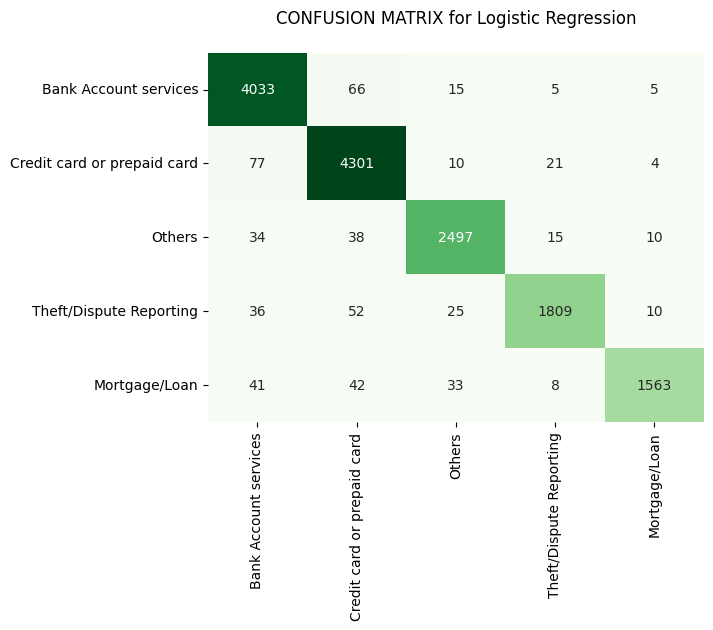

'Accuracy   : 0.9629152542372882'

In [75]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(solver='lbfgs', max_iter=1000)
logistic_regression.fit(xtrain, ytrain)

ytrain_pred = logistic_regression.predict(xtrain)
ytest_pred = logistic_regression.predict(xtest)

display("Training data accuracy\n")
training_accuracy = accuracy_evaluation(ytrain.values,ytrain_pred,'Logistic Regression')

'Test data accuracy\n'

'CLASSIFICATION REPORT for Logistic Regression\n'

'                             precision    recall  f1-score   support\n\n      Bank Account services       0.93      0.97      0.95      1768\nCredit card or prepaid card       0.94      0.97      0.95      1892\n                     Others       0.94      0.94      0.94      1111\n    Theft/Dispute Reporting       0.95      0.92      0.93       828\n              Mortgage/Loan       0.95      0.85      0.90       723\n\n                   accuracy                           0.94      6322\n                  macro avg       0.94      0.93      0.94      6322\n               weighted avg       0.94      0.94      0.94      6322\n'

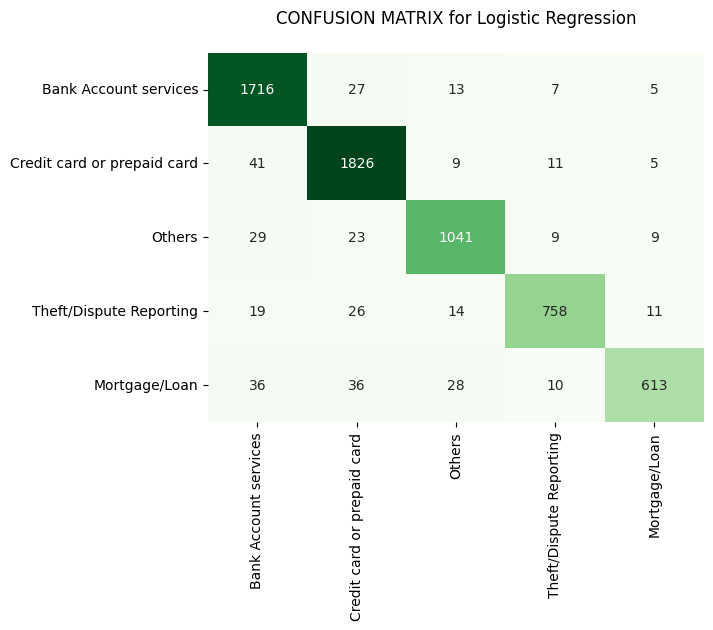

'Accuracy   : 0.9417905726036064'

In [76]:
display("Test data accuracy\n")
test_accuracy = accuracy_evaluation(ytest.values,ytest_pred,'Logistic Regression')

#### Insights for Model 1:
Training Accuracy: 96.04% </BR>
Test Accuracy: 94.7%

### Model 2: Naive Bayes

In [77]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
model_name = 'NAIVE BAYES'
nb = MultinomialNB()
nb.fit(xtrain, ytrain)
y_pred_nb = nb.predict(xtest)

In [78]:
# Hyperparameter tuning for best result
param_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=nb, 
                       param_grid=param_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(xtrain, ytrain)
display(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


{'alpha': 1, 'fit_prior': False}

In [79]:
# Creating model with best hyperparameter
model_name = 'NAIVE BAYES'
nb_tuned = MultinomialNB(alpha=1,fit_prior=False)
nb_tuned.fit(xtrain, ytrain)
ypred_train_nb_tuned = nb_tuned.predict(xtrain)
ypred_test_nb_tuned = nb_tuned.predict(xtest)

In [80]:
# Calculate F1 Score of model using weighted average method
f1_nb = metrics.f1_score(ytrain.values, ypred_train_nb_tuned, average="weighted")
display("Training f1_score : {}".format(f1_nb))

# Calculate F1 Score of model using weighted average method
f1_nb = metrics.f1_score(ytest.values, ypred_test_nb_tuned, average="weighted")
display("Test f1_score : {}".format(f1_nb))

'Training f1_score : 0.8564562533286791'

'Test f1_score : 0.8491179443106204'

'Training Accuracy\n'

'CLASSIFICATION REPORT for Naive Bayes\n'

'                             precision    recall  f1-score   support\n\n      Bank Account services       0.89      0.90      0.89      4124\nCredit card or prepaid card       0.92      0.82      0.87      4413\n                     Others       0.86      0.88      0.87      2594\n    Theft/Dispute Reporting       0.79      0.87      0.83      1932\n              Mortgage/Loan       0.71      0.79      0.75      1687\n\n                   accuracy                           0.86     14750\n                  macro avg       0.83      0.85      0.84     14750\n               weighted avg       0.86      0.86      0.86     14750\n'

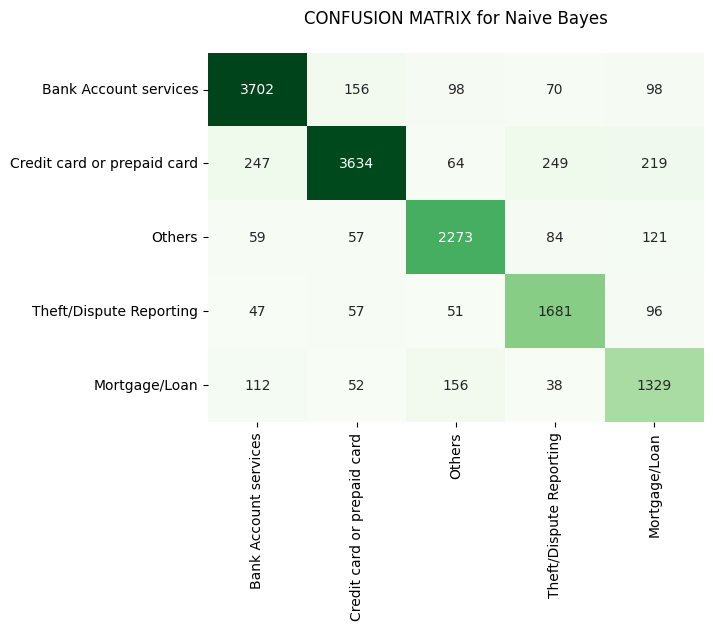

'Accuracy   : 0.8555254237288136'

In [81]:
# Evaluate the Naive Bayes classifier
display("Training Accuracy\n")
Training_acc = accuracy_evaluation(ytrain.values, ypred_train_nb_tuned, "Naive Bayes")

'Test Accuracy\n'

'CLASSIFICATION REPORT for Naive Bayes\n'

'                             precision    recall  f1-score   support\n\n      Bank Account services       0.88      0.90      0.89      1768\nCredit card or prepaid card       0.92      0.82      0.87      1892\n                     Others       0.87      0.87      0.87      1111\n    Theft/Dispute Reporting       0.80      0.86      0.83       828\n              Mortgage/Loan       0.67      0.75      0.71       723\n\n                   accuracy                           0.85      6322\n                  macro avg       0.83      0.84      0.83      6322\n               weighted avg       0.85      0.85      0.85      6322\n'

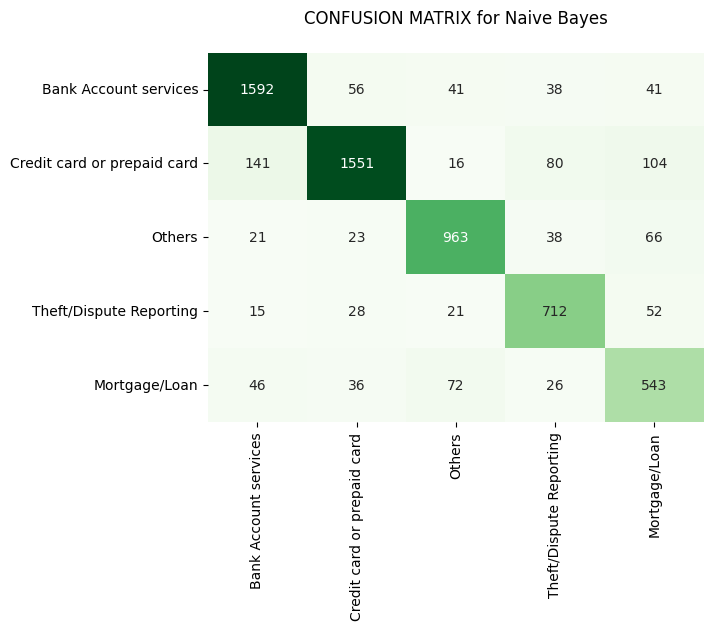

'Accuracy   : 0.8479911420436571'

In [82]:
# Evaluate the Naive Bayes classifier
display("Test Accuracy\n")
Test_acc = accuracy_evaluation(ytest.values, ypred_test_nb_tuned, "Naive Bayes")

#### Insights for Model 2:
Training Accuracy: 85.05% </BR>
Test Accuracy: 85.44%

### Model 3 : Decision Tree Classifier

'Train Accuracy'

'CLASSIFICATION REPORT for Decision Tree Classifier\n'

'                             precision    recall  f1-score   support\n\n      Bank Account services       0.87      0.78      0.82      4124\nCredit card or prepaid card       0.90      0.78      0.84      4413\n                     Others       0.72      0.87      0.79      2594\n    Theft/Dispute Reporting       0.73      0.86      0.79      1932\n              Mortgage/Loan       0.81      0.89      0.85      1687\n\n                   accuracy                           0.82     14750\n                  macro avg       0.81      0.83      0.82     14750\n               weighted avg       0.83      0.82      0.82     14750\n'

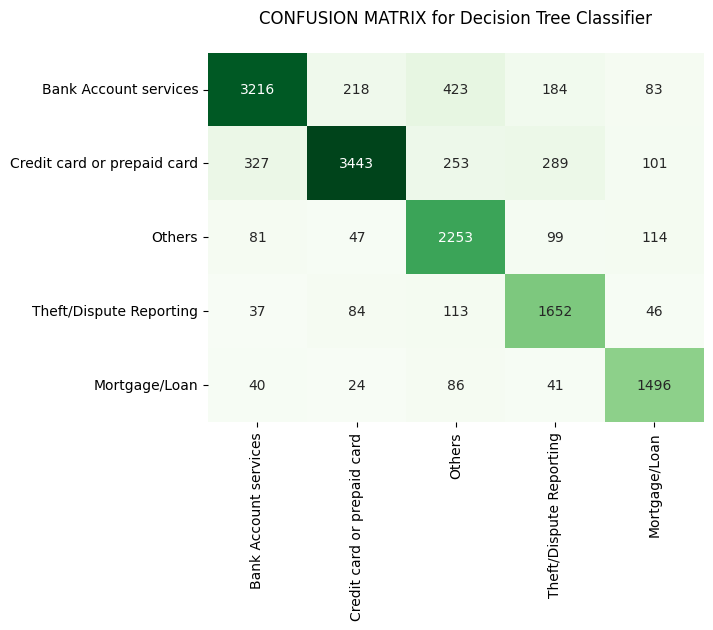

'Accuracy   : 0.8176271186440678'

In [83]:
from sklearn.tree import DecisionTreeClassifier

# Checking initial tree with standard params
dt = DecisionTreeClassifier(random_state=40, max_depth=10, min_samples_leaf = 10, class_weight="balanced")
dt.fit(xtrain,ytrain)

# predict the train and test
ytrain_pred_dt  = dt.predict(xtrain)
ytest_pred_dt = dt.predict(xtest)

# check for model accuracy
display("Train Accuracy")
train_accuracy = accuracy_evaluation(ytrain.values, ytrain_pred_dt,"Decision Tree Classifier")

'Test Accuracy'

'CLASSIFICATION REPORT for Decision Tree Classifier\n'

'                             precision    recall  f1-score   support\n\n      Bank Account services       0.84      0.77      0.80      1768\nCredit card or prepaid card       0.86      0.74      0.80      1892\n                     Others       0.70      0.84      0.76      1111\n    Theft/Dispute Reporting       0.66      0.78      0.72       828\n              Mortgage/Loan       0.72      0.76      0.74       723\n\n                   accuracy                           0.77      6322\n                  macro avg       0.76      0.78      0.76      6322\n               weighted avg       0.78      0.77      0.78      6322\n'

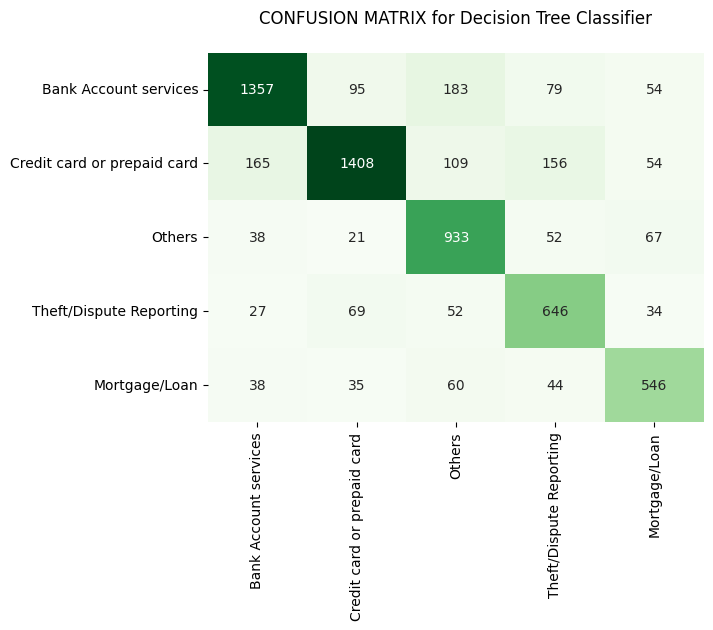

'Accuracy   : 0.7734894020879468'

In [84]:
# test data accuracy
display("Test Accuracy")
test_accuracy_dt = accuracy_evaluation(ytest.values,ytest_pred_dt,"Decision Tree Classifier")

#### Insights for Model 3:
Training Accuracy: 81.99% </BR>
Test Accuracy: 78.4%

#### Hyper Parameter Tuning Decision Tree Classifier

In [85]:
dt = DecisionTreeClassifier(random_state = 40, class_weight="balanced")

# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [5, 10, 20, 50],
    'criterion': ["entropy", "gini"]
}

grid_search = GridSearchCV(estimator = dt,param_grid = params,cv = 5, n_jobs=-1, verbose=1, scoring="accuracy", return_train_score=True)

display(grid_search.fit(xtrain, ytrain))

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=40),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [5, 10, 20, 50]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [86]:
# Get the results in tabular format
scores = grid_search.cv_results_
display(pd.DataFrame(scores).head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.427321,0.038608,0.011712,0.000909,entropy,5,5,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.698305,0.706102,...,0.705085,0.005781,25,0.717797,0.718475,0.712373,0.712712,0.714576,0.715186,0.002531
1,1.352241,0.005800,0.012291,0.002112,entropy,5,10,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.698305,0.706102,...,0.704678,0.005080,27,0.717797,0.718475,0.712373,0.711610,0.714576,0.714966,0.002773
2,1.342491,0.027126,0.010597,0.000917,entropy,5,20,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.698305,0.705763,...,0.704746,0.005295,26,0.717797,0.717797,0.712373,0.711949,0.714576,0.714898,0.002529
3,1.255276,0.015472,0.011401,0.002302,entropy,5,50,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.700339,0.703390,...,0.703322,0.005509,28,0.717627,0.717627,0.707881,0.705593,0.710254,0.711797,0.004984
4,2.207673,0.037960,0.010234,0.000475,entropy,10,5,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.761695,0.763729,...,0.765898,0.007687,20,0.834237,0.837627,0.833898,0.833390,0.834407,0.834712,0.001498


In [87]:
display(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 10}

In [88]:
dt_best = DecisionTreeClassifier(random_state=40, max_depth = 20, min_samples_leaf = 10, class_weight="balanced")
dt_best.fit(xtrain,ytrain)

ytrain_pred_dt = dt_best.predict(xtrain)
ytest_pred_dt = dt_best.predict(xtest)

'Training Data evaluation'

'CLASSIFICATION REPORT for DT Classifier Tuned\n'

'                             precision    recall  f1-score   support\n\n      Bank Account services       0.91      0.86      0.88      4124\nCredit card or prepaid card       0.92      0.84      0.88      4413\n                     Others       0.83      0.86      0.85      2594\n    Theft/Dispute Reporting       0.78      0.91      0.84      1932\n              Mortgage/Loan       0.80      0.90      0.85      1687\n\n                   accuracy                           0.86     14750\n                  macro avg       0.85      0.87      0.86     14750\n               weighted avg       0.87      0.86      0.87     14750\n'

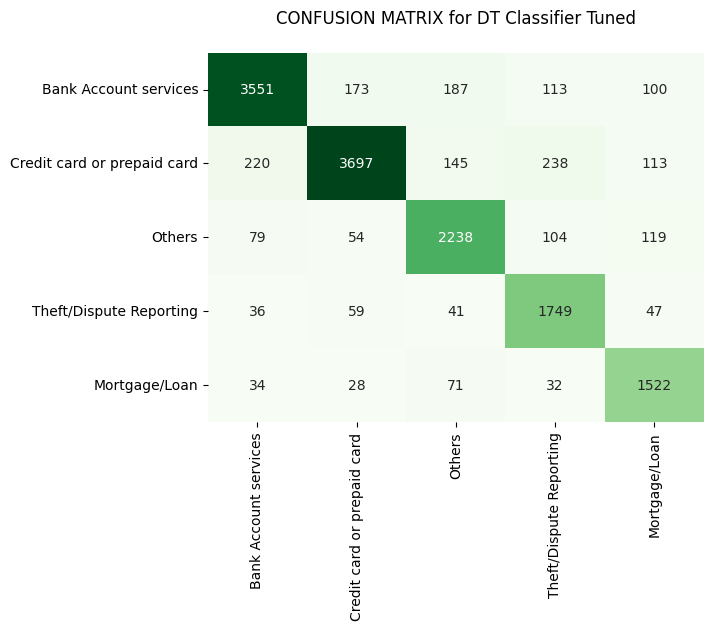

'Accuracy   : 0.8648813559322034'

In [89]:
display("Training Data evaluation")
train_accuracy_dt = accuracy_evaluation(ytrain.values,ytrain_pred_dt,"DT Classifier Tuned")

'test Data evaluation'

'CLASSIFICATION REPORT for DT Classifier Tuned\n'

'                             precision    recall  f1-score   support\n\n      Bank Account services       0.84      0.82      0.83      1768\nCredit card or prepaid card       0.86      0.78      0.82      1892\n                     Others       0.79      0.81      0.80      1111\n    Theft/Dispute Reporting       0.71      0.82      0.76       828\n              Mortgage/Loan       0.71      0.76      0.74       723\n\n                   accuracy                           0.80      6322\n                  macro avg       0.78      0.80      0.79      6322\n               weighted avg       0.80      0.80      0.80      6322\n'

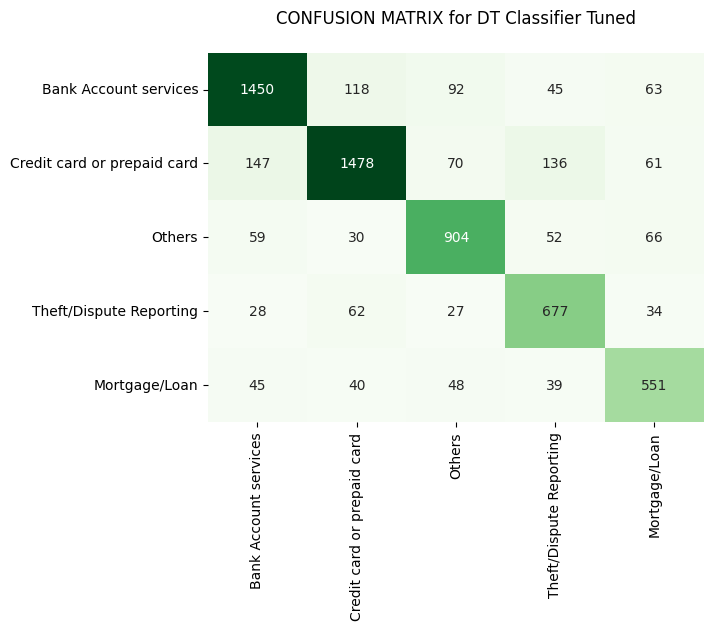

'Accuracy   : 0.8003796267004113'

In [90]:
display("test Data evaluation")
test_accuracy_dt = accuracy_evaluation(ytest.values,ytest_pred_dt,"DT Classifier Tuned")

#### Insights - Decision Tree Classifier Tuned:
Training Accuracy: 86.49% </BR>
Test Accuracy: 81.06%

### Model 4 : Random Forest Classifier

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [92]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

folds = StratifiedKFold(n_splits=4, shuffle = True, random_state=40)

param_grid = {
     'max_depth': [5, 10, 20],
     'min_samples_leaf': [10, 20, 50, 100],
     'n_estimators': [15, 20, 25, 30],
     'min_samples_split': range(10, 30, 50),
     'max_features': [5, 10, 15],
     'criterion': ["gini"]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = folds, verbose = 1, scoring="accuracy", return_train_score=True)

In [93]:
# Fitting  grid search to the data
display(grid_search.fit(xtrain, ytrain))

Fitting 4 folds for each of 144 candidates, totalling 576 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=40, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'criterion': ['gini'], 'max_depth': [5, 10, 20],
                         'max_features': [5, 10, 15],
                         'min_samples_leaf': [10, 20, 50, 100],
                         'min_samples_split': range(10, 30, 50),
                         'n_estimators': [15, 20, 25, 30]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [94]:
display(grid_search.best_score_)

rf_best = grid_search.best_estimator_
display(rf_best)

0.8572881605476708

RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=15,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=30, random_state=42)

In [ ]:
display(rf_best.fit(xtrain,ytrain))

In [ ]:
ytrain_pred_rf = rf_best.predict(xtrain)
ytest_pred_rf = rf_best.predict(xtest)

In [ ]:
display("Training Accuracy")

train_accuracy_rf = accuracy_evaluation(ytrain.values,ytrain_pred_rf,"Random Forest")

In [ ]:
display("Test Accuracy")

test_accuracy_rf = accuracy_evaluation(ytest.values,ytest_pred_rf,"Random Forest")

#### Insights for Model 4:
Training Accuracy: 89.78% </BR>
Test Accuracy: 86.34%

### Overall Insights:
Logistic Regression provides better accuracy and performs better than other models</BR>
Training Accuracy: 96.04% </BR>
Test Accuracy: 94.7%

### Model Inference using Logistic Regression

In [ ]:
Topic_names_index = {}
for key in Topic_names:
    Topic_names_index[Topic_names[key]] = key
display(Topic_names_index)

In [ ]:
def Topic_Predictor(sentence, model = logistic_regression):
    vect_custom = count_vector.transform(pd.Series(sentence))
    word_vect_custom = tfidf_transformer.transform(vect_custom)

    word_vect_custom_df = pd.DataFrame(word_vect_custom.toarray(),columns=count_vector.get_feature_names_out()) #Convert to data frame
    custom_pred = model.predict(word_vect_custom_df) # Make predictions
     
    return Topic_names_index[custom_pred[0]]

In [ ]:
custom_text = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "unwanted service activated and money deducted automatically ",
                                  "How can I know my CIBIL score?",
                                  "Where are the bank branches in the city of Patna?",
                                 "This letter is to dispute an incorrectly charged amount on my credit card. My credit card number is XCXCXXC and it has a constant charges"
                                          ,"I want to report an incident of theft of my credit card.",
                                          "I would like to convert my account into premium account to avail latest benefits.",
                                          "I am buying a new house, based on my current salary I should get a good loan."]})
display(custom_text)

In [ ]:
custom_text['predicted topic'] = custom_text['complaints'].apply(lambda x: Topic_Predictor([x]))
display(
    custom_text
)

## Conclusion : </br>
Logistic Regression provides better accuracy and performs better than other models

In [ ]:
import datetime, pytz; 
print("Current Time in IST:", datetime.datetime.now(pytz.utc).astimezone(pytz.timezone('Asia/Kolkata')).strftime('%Y-%m-%d %H:%M:%S'))